In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# VGG-16 và VGG-19

##Preparing

In [ ]:
from tensorflow.keras.preprocessing import image_dataset_from_directory
import numpy as np

In [ ]:
names = ['Apple Braeburn','Apple Golden','Apple Granny Smith','Apple Pink Lady','Apple Red Yellow',
        'Apricot','Avocado','Banana Red','Banana','Beetroot',
         'Blueberry','Cactus fruit','Cauliflower','Cherry Yellow','Coconut',
         'Corn or Maize','Daisy','Dandelion','Tulips','Watermelon'
]

In [ ]:
len(names)

20

In [ ]:
image_size = 224
img_channel = 3 #Ảnh màu RGB
batch_size = 64
color_mode = 'rgb'

##Data

In [ ]:
train_data = image_dataset_from_directory(
    '/content/drive/MyDrive/Colab Notebooks/DEEP/Fruit_Flower_Veg_Train_Dev',
    labels = 'inferred', #lấy tên label là tên của thư mục
    label_mode = 'categorical', #phân lớp 2 biến đầu ra => nhị phân
    class_names = names,
    color_mode = color_mode,
    batch_size = batch_size,
    image_size = (image_size, image_size),
    interpolation = 'bilinear', #Thông số mặc định
)

Found 14985 files belonging to 20 classes.


In [ ]:
dev_data = image_dataset_from_directory(
    '/content/drive/MyDrive/Colab Notebooks/DEEP/Fruit_Flower_Veg_Train_Dev',
    labels = 'inferred', #lấy tên label là tên của thư mục
    label_mode = 'categorical', #phân lớp 2 biến đầu ra => nhị phân
    class_names = names,
    color_mode = color_mode,
    batch_size = batch_size,
    image_size = (image_size, image_size),
    interpolation = 'bilinear', #Thông số mặc định
    subset = "validation",
    seed = 1,
    validation_split = 0.1,
)

Found 14985 files belonging to 20 classes.
Using 1498 files for validation.


In [ ]:
test_data = image_dataset_from_directory(
    '/content/drive/MyDrive/Colab Notebooks/DEEP/Fruit_Flower_Veg_Test',
    labels = 'inferred', #lấy tên label là tên của thư mục
    label_mode = 'categorical', #phân lớp 2 biến đầu ra => nhị phân
    class_names = names,
    color_mode = color_mode,
    batch_size = batch_size,
    image_size = (image_size, image_size),
    interpolation = 'bilinear', #Thông số mặc định
)

Found 4005 files belonging to 20 classes.


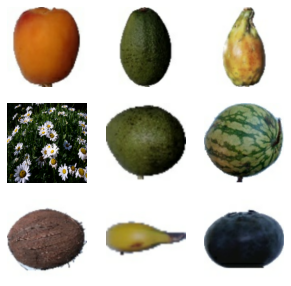

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize = (5,5))
for images, labels in train_data.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i+1)
    plt.imshow(np.squeeze(images[i].numpy().astype("uint8")))
    plt.axis("off")

## VGG-16

### Huấn luyện mô hình

In [ ]:
import numpy as np

#image_shape = (227,227,3)
#np.random.seed(1000)

# VGG-16 pre-trained

from keras.applications.vgg16 import VGG16
from keras.layers import Flatten, Dense, Dropout
from keras.models import Model, Input
from keras.regularizers import l2

vgg16 = VGG16(include_top=False, input_shape=(image_size, image_size, img_channel))

for layer in vgg16.layers:
  layer.trainable = False

flat = Flatten()(vgg16.layers[-1].output)
model_vgg16 = Dropout(0.2)(flat)
output = Dense(20, activation='sigmoid')(model_vgg16)
model_vgg16 = Model(inputs=vgg16.inputs, outputs=output)

model_vgg16.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])
model_vgg16.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

In [ ]:
from keras.callbacks import EarlyStopping
callback = EarlyStopping(monitor="val_loss", patience=1)

history_vgg16 = model_vgg16.fit(train_data, epochs = 10, validation_data=dev_data, callbacks=(callback))

Epoch 1/10
235/235 [==============================] - 72s 299ms/step - loss: 1.4324 - accuracy: 0.9534 - val_loss: 0.0805 - val_accuracy: 0.9967
Epoch 2/10
235/235 [==============================] - 73s 308ms/step - loss: 0.2871 - accuracy: 0.9903 - val_loss: 0.0799 - val_accuracy: 0.9967
Epoch 3/10
235/235 [==============================] - 74s 310ms/step - loss: 0.1675 - accuracy: 0.9933 - val_loss: 0.1380 - val_accuracy: 0.9947


### Đánh giá mô hình

<Figure size 432x288 with 0 Axes>

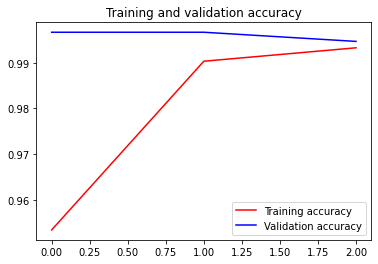

<Figure size 432x288 with 0 Axes>

In [ ]:
import matplotlib.pyplot as plt
acc = history_vgg16.history['accuracy']
val_acc = history_vgg16.history['val_accuracy']
loss = history_vgg16.history['loss']
val_loss = history_vgg16.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()

In [ ]:
model_vgg16.save('model_VGG16.h5')

In [ ]:
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score
import numpy as np

y_pred_total = []
y_true = []

for img, label in test_data:
    y_pred = model_vgg16.predict(img)
    y_pred_total += np.argmax(y_pred,axis=-1).tolist()
    y_true += np.array(np.argmax(label,axis=-1)).flatten().tolist()
    
print(accuracy_score(y_true, y_pred_total)*100)
print(f1_score(y_true, y_pred_total,average='macro')*100)
print(recall_score(y_true,y_pred_total,average='macro')*100)
print(precision_score(y_true,y_pred_total,average='macro')*100)

60.37453183520599
49.73926880319091
53.71369863240466
61.02225293392705


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_true, y_pred_total, digits=3))

              precision    recall  f1-score   support

           0      0.752     1.000     0.859       164
           1      0.328     0.945     0.487       164
           2      0.985     0.409     0.578       164
           3      0.407     0.750     0.528       152
           4      0.200     0.238     0.217       164
           5      1.000     0.116     0.208       164
           6      0.532     0.986     0.691       143
           7      0.386     0.904     0.541       166
           8      1.000     0.765     0.867       166
           9      0.267     0.673     0.383       150
          10      1.000     0.396     0.567       154
          11      1.000     0.151     0.262       166
          12      0.992     0.517     0.680       234
          13      0.000     0.000     0.000       164
          14      0.104     0.048     0.066       166
          15      0.535     0.460     0.495       150
          16      0.899     0.951     0.925       761
          17      0.860    

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#Predict

In [ ]:
import numpy as np
from google.colab import files
from keras.preprocessing import image

uploaded = files.upload()

for fn in uploaded.keys():
 
  # predicting images
  path = fn
  img = image.load_img(path, target_size=(224, 224))
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)

  images = np.vstack([x])
  classes = model.predict(images, batch_size=10)
  print(fn)
  print(classes)

In [ ]:
  print(classes)

In [ ]:
names[np.argmax(classes)]

## VGG19

In [ ]:
import numpy as np

#image_shape = (227,227,3)
#np.random.seed(1000)

# VGG-16 pre-trained

from keras.applications.vgg19 import VGG19
from keras.layers import Flatten, Dense, Dropout
from keras.models import Model, Input
from keras.regularizers import l2


vgg19 = VGG19(include_top=False, input_shape=(image_size, image_size, img_channel))

for layer in vgg19.layers:
  layer.trainable = False

flat = Flatten()(vgg19.layers[-1].output)
model_vgg19 = Dropout(0.001)(flat)
output = Dense(20, activation='sigmoid')(model_vgg19)
model_vgg19 = Model(inputs=vgg19.inputs, outputs=output)

model_vgg19.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])
model_vgg19.summary()


80150528/80134624 [==============================] - 1s 0us/step
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                            

In [ ]:
history_vgg19 = model_vgg19.fit(train_data, epochs = 10, validation_data=dev_data)

Epoch 1/10
235/235 [==============================] - 83s 346ms/step - loss: 1.3216 - accuracy: 0.9529 - val_loss: 0.1961 - val_accuracy: 0.9900
Epoch 2/10
235/235 [==============================] - 82s 345ms/step - loss: 0.3748 - accuracy: 0.9905 - val_loss: 0.1210 - val_accuracy: 0.9927
Epoch 3/10
235/235 [==============================] - 86s 360ms/step - loss: 0.1164 - accuracy: 0.9942 - val_loss: 0.0615 - val_accuracy: 0.9973
Epoch 4/10
235/235 [==============================] - 83s 350ms/step - loss: 0.0910 - accuracy: 0.9955 - val_loss: 0.2241 - val_accuracy: 0.9907
Epoch 5/10
235/235 [==============================] - 82s 343ms/step - loss: 0.0655 - accuracy: 0.9967 - val_loss: 0.1358 - val_accuracy: 0.9960
Epoch 6/10
235/235 [==============================] - 85s 360ms/step - loss: 0.0416 - accuracy: 0.9982 - val_loss: 0.0720 - val_accuracy: 0.9967
Epoch 7/10
235/235 [==============================] - 82s 344ms/step - loss: 0.1086 - accuracy: 0.9968 - val_loss: 0.1149 - val_ac

<Figure size 432x288 with 0 Axes>

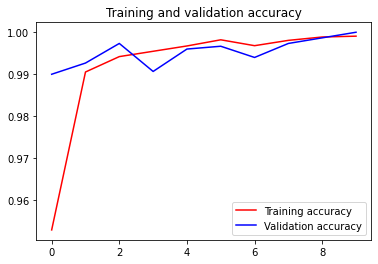

<Figure size 432x288 with 0 Axes>

In [ ]:
import matplotlib.pyplot as plt
acc = history_vgg19.history['accuracy']
val_acc = history_vgg19.history['val_accuracy']
loss = history_vgg19.history['loss']
val_loss = history_vgg19.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()

In [ ]:
model_vgg19.save('model_VGG19.h5')

In [ ]:
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score
import numpy as np

y_pred_total = []
y_true = []

for img, label in test_data:
    y_pred = model_vgg19.predict(img)
    y_pred_total += np.argmax(y_pred,axis=-1).tolist()
    y_true += np.array(np.argmax(label,axis=-1)).flatten().tolist()
    
print(accuracy_score(y_true, y_pred_total)*100)
print(f1_score(y_true, y_pred_total,average='macro')*100)
print(recall_score(y_true,y_pred_total,average='macro')*100)
print(precision_score(y_true,y_pred_total,average='macro')*100)

57.77777777777777
48.89690640336081
50.95144015551838
67.80746968002379


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_true, y_pred_total, digits=3))

              precision    recall  f1-score   support

           0      0.816     1.000     0.899       164
           1      0.430     1.000     0.602       164
           2      0.346     0.220     0.269       164
           3      0.303     0.908     0.454       152
           4      0.116     0.494     0.188       164
           5      1.000     0.006     0.012       164
           6      0.565     0.671     0.613       143
           7      0.939     0.837     0.885       166
           8      0.981     0.946     0.963       166
           9      0.429     0.380     0.403       150
          10      0.785     0.403     0.532       154
          11      0.854     0.530     0.654       166
          12      0.319     0.128     0.183       234
          13      0.000     0.000     0.000       164
          14      1.000     0.181     0.306       166
          15      1.000     0.080     0.148       150
          16      0.837     0.971     0.899       761
          17      0.869    

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
